## 1. Problem Statement

Goal: Detect study behavior drift and performance changes using student activity data.


In [27]:
# All imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

In [28]:
df=pd.read_csv('synthetic_study_drift_dataset.csv')
df.head()

,date,study_hours,break_minutes,focus_score,difficulty_level,time_of_day,topic_consistency,quiz_score
0,2026-01-01,3.5,25,78,medium,morning,0.85,88
1,2026/01/02,4,NaN,82,High,evening,0.9,91
2,2026-01-03,2.75,30,min,Medium,afternoon,0.76,?
3,01-04-2026,NaN,20,70,low,Morning,0.61,77
4,2026-1-05,3.0,15,85,Medium,night,0.94,89


In [29]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               147 non-null    object
 1   study_hours        133 non-null    object
 2   break_minutes      141 non-null    object
 3   focus_score        144 non-null    object
 4   difficulty_level   147 non-null    object
 5   time_of_day        147 non-null    object
 6   topic_consistency  147 non-null    object
 7   quiz_score         146 non-null    object
dtypes: object(8)
memory usage: 9.3+ KB


## Data Cleaning


In [30]:
# Convert numerics
numeric_cols = ['study_hours', 'break_minutes', 'focus_score', 'topic_consistency', 'quiz_score']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill NaNs with medians
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Clean difficulty_level
if 'difficulty_level' in df.columns:
    df['difficulty_level'] = df['difficulty_level'].astype(str).str.lower().str.strip()
    diff_map = {'low': 1, 'medium': 2, 'mid': 2, 'med': 2, 'high': 3, 'very high': 4}
    df['difficulty_level'] = df['difficulty_level'].map(diff_map).fillna(2)  # default medium

# Time category
if 'time_of_day' in df.columns:
    df['time_category'] = np.where(df['time_of_day'].str.contains('night', na=False), 1, 0)

# Sort by date
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.sort_values('date').reset_index(drop=True)


print(df[numeric_cols + ['difficulty_level', 'time_category']].isnull().sum())
display(df.head())
df.describe()

study_hours          0
break_minutes        0
focus_score          0
topic_consistency    0
quiz_score           0
difficulty_level     0
time_category        0
dtype: int64


,date,study_hours,break_minutes,focus_score,difficulty_level,time_of_day,topic_consistency,quiz_score,time_category
0,2026-01-01,3.50,25.0,78.0,2.0,morning,0.85,88.0,0
1,2026-01-03,2.75,30.0,77.0,2.0,afternoon,0.76,83.0,0
2,2026-01-05,3.00,15.0,85.0,2.0,night,0.94,89.0,1
3,2026-01-06,4.50,24.0,77.0,2.0,night,92.00,83.0,1
4,2026-01-07,2.25,18.0,67.0,1.0,afternoon,0.59,65.0,0


,date,study_hours,break_minutes,focus_score,difficulty_level,topic_consistency,quiz_score,time_category
count,79,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000
mean,2026-02-28 13:22:01.518987264,3.216667,24.952381,74.925170,2.013605,1.384490,78.387755,0.102041
min,2026-01-01 00:00:00,1.500000,9.000000,45.000000,1.000000,0.440000,43.000000,0.000000
25%,2026-01-29 12:00:00,2.500000,18.000000,64.500000,1.000000,0.610000,62.500000,0.000000
50%,2026-02-28 00:00:00,3.200000,24.000000,77.000000,2.000000,0.810000,83.000000,0.000000
75%,2026-03-30 00:00:00,3.900000,30.000000,85.500000,2.000000,0.900000,91.000000,0.000000
max,2026-04-29 00:00:00,5.000000,52.000000,99.000000,4.000000,92.000000,105.000000,1.000000
std,NaN,0.873493,9.782801,14.240156,0.867893,7.526753,16.946915,0.303737


## EDA

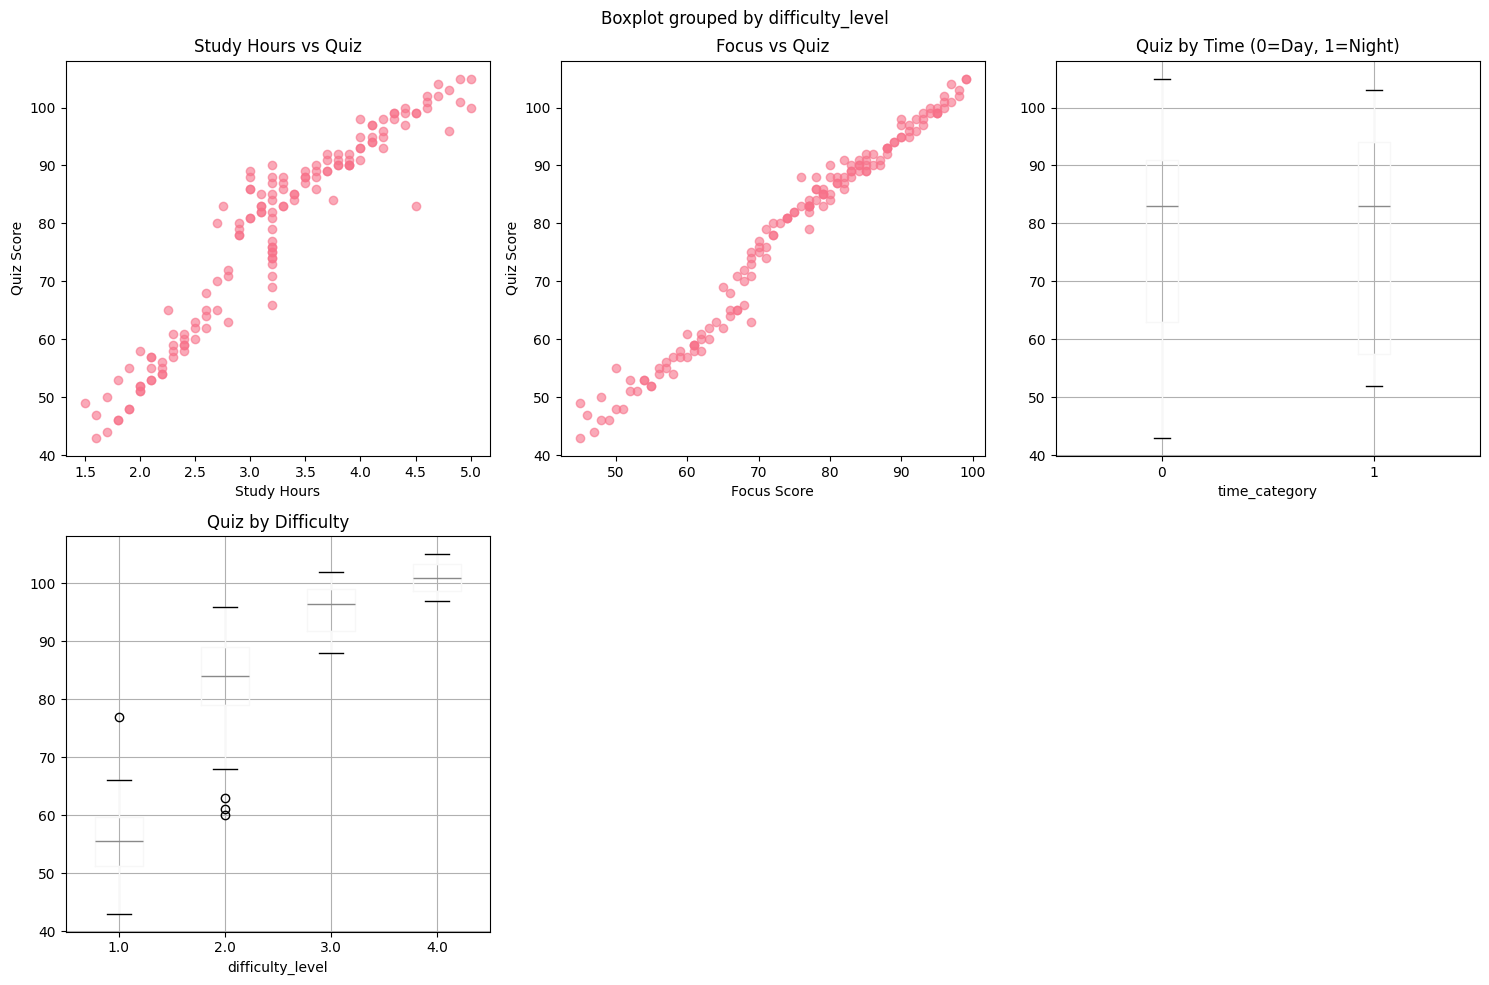

In [31]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.scatter(df['study_hours'], df['quiz_score'], alpha=0.6)
plt.xlabel('Study Hours'); plt.ylabel('Quiz Score'); plt.title('Study Hours vs Quiz')

plt.subplot(2, 3, 2)
plt.scatter(df['focus_score'], df['quiz_score'], alpha=0.6)
plt.xlabel('Focus Score'); plt.ylabel('Quiz Score'); plt.title('Focus vs Quiz')

plt.subplot(2, 3, 3)
df.boxplot(column='quiz_score', by='time_category', ax=plt.gca())
plt.title('Quiz by Time (0=Day, 1=Night)')

plt.subplot(2, 3, 4)
df.boxplot(column='quiz_score', by='difficulty_level', ax=plt.gca())
plt.title('Quiz by Difficulty')


plt.tight_layout()
plt.show()

## Model Training


In [32]:
# Features & Target
features = ['study_hours', 'break_minutes', 'focus_score', 'difficulty_level', 'topic_consistency', 'time_category']
X = df[features].dropna()
y = df.loc[X.index, 'quiz_score']

# Split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx].copy(), X.iloc[split_idx:].copy()
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate
print(f"LR R² train: {r2_score(y_train, lr_model.predict(X_train_scaled)):.3f}")
print(f"RF R² train: {r2_score(y_train, rf_model.predict(X_train)):.3f}")

Train: (117, 6), Test: (30, 6)
LR R² train: 0.974
RF R² train: 0.998


## Model Eval

TEST RESULTS:
Linear Regression: R²=0.989, RMSE=1.8
Random Forest:    R²=0.991, RMSE=1.6


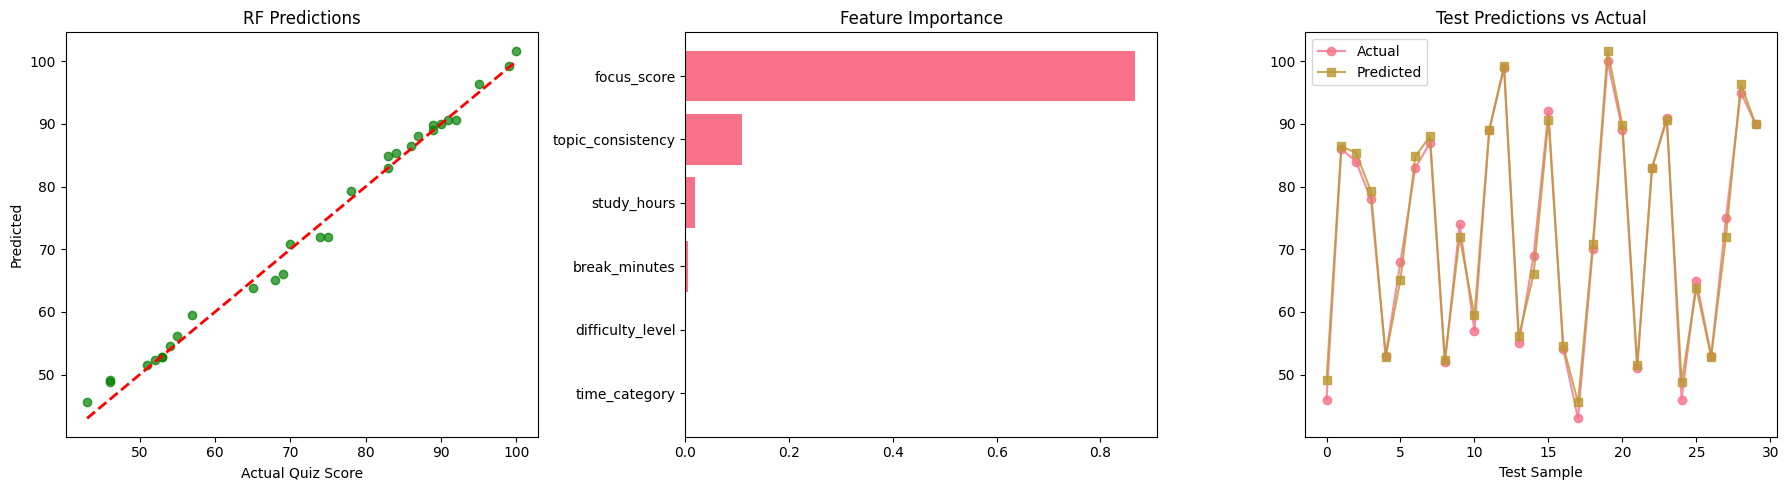

In [33]:
# Predictions
lr_pred = lr_model.predict(X_test_scaled)
rf_pred = rf_model.predict(X_test)

print("TEST RESULTS:")
print(f"Linear Regression: R²={r2_score(y_test, lr_pred):.3f}, RMSE={np.sqrt(mean_squared_error(y_test, lr_pred)):.1f}")
print(f"Random Forest:    R²={r2_score(y_test, rf_pred):.3f}, RMSE={np.sqrt(mean_squared_error(y_test, rf_pred)):.1f}")

# Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predictions vs Actual
axes[0].scatter(y_test, rf_pred, alpha=0.7, color='green')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Quiz Score'); axes[0].set_ylabel('Predicted'); axes[0].set_title('RF Predictions')

# Feature Importance
importances = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)
axes[1].barh(importances['feature'], importances['importance'])
axes[1].set_title('Feature Importance')

# Time series
axes[2].plot(y_test.values, 'o-', label='Actual', alpha=0.8)
axes[2].plot(rf_pred, 's-', label='Predicted', alpha=0.8)
axes[2].legend(); axes[2].set_title('Test Predictions vs Actual'); axes[2].set_xlabel('Test Sample')

plt.tight_layout()
plt.show()